In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import progressbar
from google.colab import drive
import scipy.ndimage
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import tensorflow as tf

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imoprting the data, resizing and saving them in drive

In [ ]:
base_directory='/content/drive/My Drive/lsp_dataset/images'
images_directory=os.listdir(base_directory)
images_directory.sort()
target_size=(220,220)
resized_images=[]
resized_poses=[]
original_scale=[]
poses=scipy.io.loadmat('/content/drive/My Drive/lsp_dataset/joints.mat')['joints']
for idx,x in progressbar.progressbar(enumerate(images_directory)):
    path=os.path.join(base_directory,x)
    image = plt.imread(path)
    height,width=image.shape[0],image.shape[1]
    scale_w,scale_h=220/width,220/height
    original_scale.append([width,height])
    resized_poses.append([poses[0,:,idx]*scale_w,poses[1,:,idx]*scale_h])
    image=cv2.resize(image,target_size,interpolation=cv2.INTER_AREA)
    resized_images.append(image)
resized_images=np.array(resized_images)
resized_poses=np.array(resized_poses)
original_scale=np.array(original_scale)
np.save('/content/drive/My Drive/lsp_dataset/Leeds Sports Dataset NPY.npy',resized_images[:1500])
np.save('/content/drive/My Drive/lsp_dataset/Resized Poses.npy',resized_poses[:1500])
np.save('/content/drive/My Drive/lsp_dataset/Image scale.npy',original_scale[:1500])
np.save('/content/drive/My Drive/lsp_dataset/Leeds Sports Dataset NPY Test.npy',resized_images[1500:])
np.save('/content/drive/My Drive/lsp_dataset/Resized Poses Test.npy',resized_poses[1500:])
np.save('/content/drive/My Drive/lsp_dataset/Image scale Test.npy',original_scale[1500:])

| |            #                                   | 1999 Elapsed Time: 0:00:08


In [3]:
aa = np.load('/content/drive/My Drive/lsp_dataset/Leeds Sports Dataset NPY.npy')
bb = np.load('/content/drive/My Drive/lsp_dataset/Resized Poses.npy')

test_image = np.load('/content/drive/My Drive/lsp_dataset/Leeds Sports Dataset NPY Test.npy')
test_label = np.load('/content/drive/My Drive/lsp_dataset/Resized Poses Test.npy')

aa = aa.astype('float32')
test_image = test_image.astype('float32')

aa = aa/255
test_image = test_image/255

# Plotting some of train data 

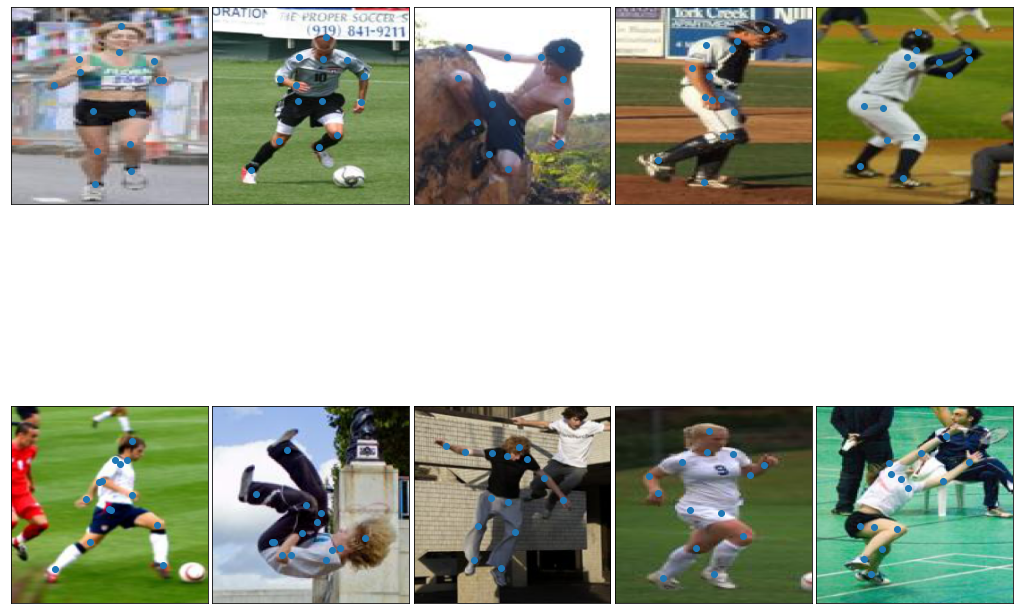

In [ ]:
fig , ax = plt.subplots(nrows=2, ncols= 5, figsize = (14, 14), sharex=True, sharey=True)
ax = ax.flatten()

for i, a in enumerate(ax):   
    a.imshow(aa[i])
    a.scatter(bb[i, 0], bb[i, 1])
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout(0.1)
plt.grid(False)

# Function to augment images and create augmented images

In [4]:
def augment_images(poses, images, k=True):
  seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(0.5, iaa.Affine(
        scale={"x": (0.5, 1.2), "y": (0.5, 1.2)},
        translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)},
        rotate=(-20, 20),
        shear=(-8, 8)
    )),
    # apply from 0 to 3 of the augmentations from the list
    iaa.Sometimes(0.25,iaa.LinearContrast((0.75, 1.4)))
  ], random_order=True)
  new_images=[]
  new_poses=[]
  if k:
    z = np.zeros((1500, 2, 14))
    immgs = np.zeros((1500, 220, 220, 3))
  else : 
     z = np.zeros((1000, 2, 14))
     immgs = np.zeros((1000, 220, 220, 3))
  if k:
    for idx in range(images.shape[0]):
        x,y= poses[idx][0],poses[idx][1]
        image=images[idx]
        kps = KeypointsOnImage([
        Keypoint(x=x[0], y=y[0]),
        Keypoint(x=x[1], y=y[1]),
        Keypoint(x=x[2], y=y[2]),
        Keypoint(x=x[3], y=y[3]),
        Keypoint(x=x[4], y=y[4]),
        Keypoint(x=x[5], y=y[5]),
        Keypoint(x=x[6], y=y[6]),
        Keypoint(x=x[7], y=y[7]),
        Keypoint(x=x[8], y=y[8]),
        Keypoint(x=x[9], y=y[9]),
        Keypoint(x=x[10], y=y[10]),
        Keypoint(x=x[11], y=y[11]),
        Keypoint(x=x[12], y=y[12]),
        Keypoint(x=x[13], y=y[13])
        ], shape=image.shape)
        new_image , new_pose = seq(image= image, keypoints = kps)
        new_image = new_image.reshape((1, )+ new_image.shape)
        x= []
        y = []
        for i in range(len(new_pose.keypoints)):
          x.append(new_pose.keypoints[i].x)
          y.append(new_pose.keypoints[i].y)
        x = np.array(x)
        y = np.array(y)
        x = x.reshape((1, ) + x.shape)
        y = y.reshape((1, ) + y.shape)
        c = np.concatenate((x, y), axis=0)
        c = c.reshape((1, ) + c.shape)
        immgs[idx] = new_image
        z[idx] = c
  else:
    for idx in range(images.shape[0] - 500):
        x,y= poses[idx][0],poses[idx][1]
        image=images[idx]
        kps = KeypointsOnImage([
        Keypoint(x=x[0], y=y[0]),
        Keypoint(x=x[1], y=y[1]),
        Keypoint(x=x[2], y=y[2]),
        Keypoint(x=x[3], y=y[3]),
        Keypoint(x=x[4], y=y[4]),
        Keypoint(x=x[5], y=y[5]),
        Keypoint(x=x[6], y=y[6]),
        Keypoint(x=x[7], y=y[7]),
        Keypoint(x=x[8], y=y[8]),
        Keypoint(x=x[9], y=y[9]),
        Keypoint(x=x[10], y=y[10]),
        Keypoint(x=x[11], y=y[11]),
        Keypoint(x=x[12], y=y[12]),
        Keypoint(x=x[13], y=y[13])
        ], shape=image.shape)
        new_image , new_pose = seq(image= image, keypoints = kps)
        new_image = new_image.reshape((1, )+ new_image.shape)
        x= []
        y = []
        for i in range(len(new_pose.keypoints)):
          x.append(new_pose.keypoints[i].x)
          y.append(new_pose.keypoints[i].y)
        x = np.array(x)
        y = np.array(y)
        x = x.reshape((1, ) + x.shape)
        y = y.reshape((1, ) + y.shape)
        c = np.concatenate((x, y), axis=0)
        c = c.reshape((1, ) + c.shape)
        immgs[idx] = new_image
        z[idx] = c
  return immgs, z

In [6]:
new_immg = np.zeros((4000, 220, 220, 3))
new_pose = np.zeros((4000, 2, 14))
new_immg[:1500] = aa
new_pose[:1500] = bb
new_immg[1500:3000], new_pose[1500:3000] = augment_images(bb, aa)
new_immg[3000:], new_pose[3000:] = augment_images(bb, aa, k=False)


In [7]:
#np.save('/content/drive/My Drive/lsp_dataset/Leeds Sports Dataset (Augmented2) NPY.npy',new_immg)
#np.save('/content/drive/My Drive/lsp_dataset/Resized Poses(Augmented2).npy',new_pose)

In [5]:
new_immg=np.load('/content/drive/My Drive/lsp_dataset/Leeds Sports Dataset (Augmented2) NPY.npy')
new_pose=np.load('/content/drive/My Drive/lsp_dataset/Resized Poses(Augmented2).npy')

# Normalizing the labels to lie between -1 and 1 as the paper has mentioned

In [6]:
test_label =  test_label/220*2-1
new_pose = new_pose/220*2-1

In [7]:
test_label = test_label.reshape(test_label.shape[:-2] + (-1,))
new_pose = new_pose.reshape(new_pose.shape[:-2] + (-1,))

# Some example of augmented images

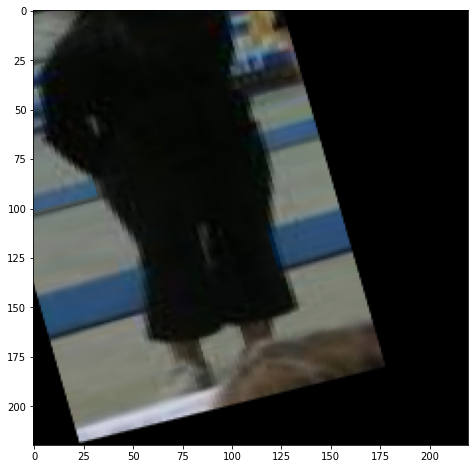

In [ ]:
#new_pose2.shape
fig, ax = plt.subplots(figsize = (8, 8))
ax.imshow(new_immg[-7]/255)

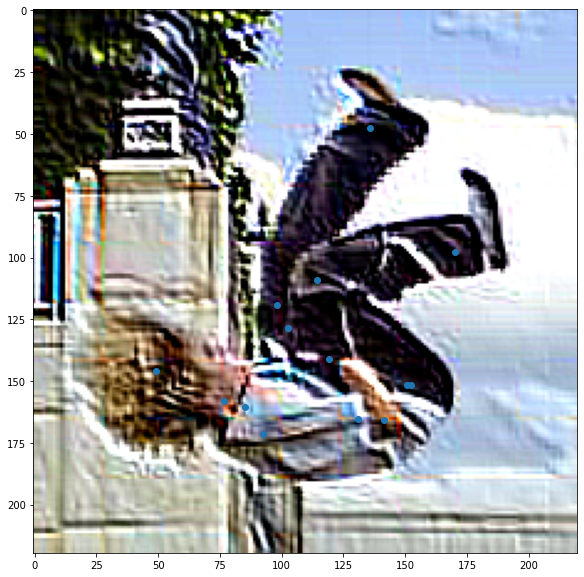

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(image[6]/255)
ax.scatter(pose[6][0], pose[6][1])

# implementing the network that paper has mentioned

In [8]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape = (220, 220, 3)))
model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(4096,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(4096,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(28,activation='linear'))

In [9]:
#Setting optmizer
optimizer = tf.keras.optimizers.Adam(lr=0.0005)

#compiling the model
model.compile(optimizer= optimizer,
            loss=tf.keras.losses.mse, metrics=['acc'])

history = model.fit(new_immg, new_pose, batch_size=128, epochs=50,
                    validation_data=(test_image, test_label))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
32/32 [==============================] - 29s 491ms/step - loss: 0.1324 - acc: 0.3877 - val_loss: 0.0868 - val_acc: 0.3920
Epoch 2/50
32/32 [==============================] - 14s 426ms/step - loss: 0.0929 - acc: 0.4087 - val_loss: 0.0872 - val_acc: 0.4720
Epoch 3/50
32/32 [==============================] - 14s 426ms/step - loss: 0.0842 - acc: 0.4108 - val_loss: 0.0861 - val_acc: 0.3960
Epoch 4/50
32/32 [==============================] - 14s 429ms/step - loss: 0.0824 - acc: 0.4067 - val_loss: 0.0858 - val_acc: 0.4700
Epoch 5/50
32/32 [==============================] - 14s 424ms/step - loss: 0.0817 - acc: 0.4030 - val_loss: 0.0850 - val_acc: 0.4060
Epoch 6/50
32/32 [==============================] - 14s 424ms/step - loss: 0.0804 - acc: 0.3918 - val_loss: 0.0844 - val_acc: 0.4240
Epoch 7/50
32/32 [==============================] - 14s 429ms/step - loss: 0.0789 - acc: 0.3965 - val_loss: 0.0819 - val_acc: 0.4560
Epoch 8/50
32/32 [==============================] - 14s 434ms/step - 

In [82]:
a = model.predict(test_image)

In [83]:
a = (a+1)/2*220

In [59]:
kaka = (test_label+1)/2*220

# Figures

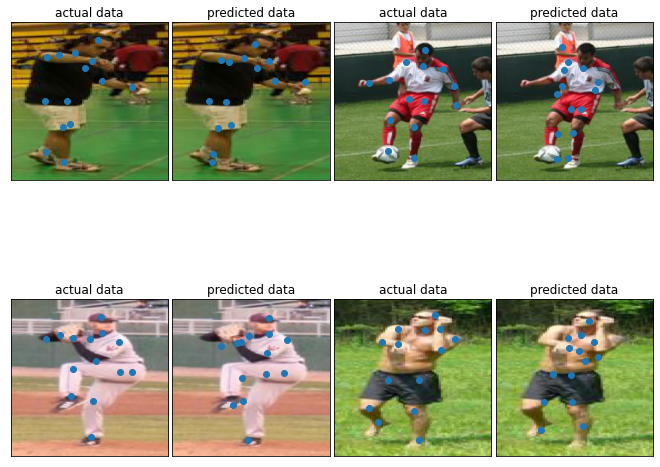

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols= 4, figsize =(9,9), sharex=True, sharey=True)
ax[0, 0].imshow(test_image[200])
ax[0, 0].scatter(kaka[200][:14],kaka[200][14:])
ax[0, 0].set(title= 'actual data')

ax[0, 1].imshow(test_image[200])
ax[0, 1].scatter(a[200][:14],a[200][14:])
ax[0, 1].set(title= 'predicted data')

ax[0, 2].imshow(test_image[140])
ax[0, 2].scatter(kaka[140][:14],kaka[140][14:])
ax[0, 2].set(title= 'actual data')

ax[0, 3].imshow(test_image[140])
ax[0, 3].scatter(a[140][:14],a[140][14:])
ax[0, 3].set(title= 'predicted data')

ax[1, 0].imshow(test_image[90])
ax[1, 0].scatter(kaka[90][:14],kaka[90][14:])
ax[1, 0].set(title= 'actual data')

ax[1, 1].imshow(test_image[90])
ax[1, 1].scatter(a[90][:14],a[90][14:])
ax[1, 1].set(title= 'predicted data')

ax[1, 2].imshow(test_image[400])
ax[1, 2].scatter(kaka[400][:14],kaka[400][14:])
ax[1, 2].set(title= 'actual data')
ax[1, 3].imshow(test_image[400])
ax[1, 3].scatter(a[400][:14],a[400][14:])
ax[1, 3].set(title= 'predicted data')



ax[0,0].set_yticks([])
ax[0,0].set_xticks([])
plt.tight_layout(0.1)
plt.grid(False)

Note that since number of data is really low so we decreased it with some augmentation and if we wanted to save some of them for validation then the number of training data would've been so low, so we kept all the training and 500 data for test which is named as validation in the below plots

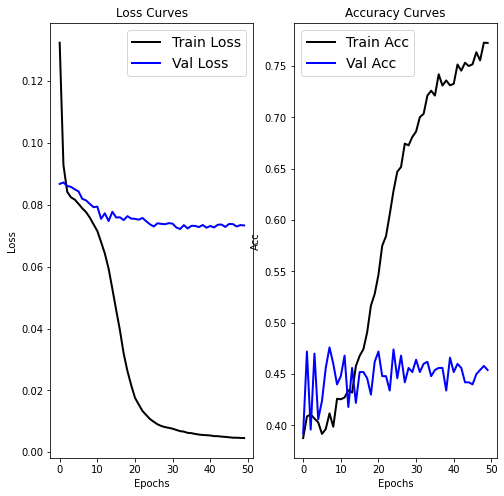

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (8, 8))
ax[0].plot(history.history['loss'], 'black', linewidth=2.0)
ax[0].plot(history.history['val_loss'], 'blue', linewidth=2.0)
ax[0].legend(['Train Loss', 'Val Loss'], fontsize=14)
ax[0].set(xlabel= 'Epochs'
            , ylabel= 'Loss'
            , title= 'Loss Curves');
ax[1].plot(history.history['acc'], 'black', linewidth=2.0)
ax[1].plot(history.history['val_acc'], 'blue', linewidth=2.0)
ax[1].legend(['Train Acc', 'Val Acc'], fontsize=14)
ax[1].set(xlabel= 'Epochs'
            , ylabel= 'Acc'
            , title= 'Accuracy Curves');

# Metrics

In [24]:
import scipy.spatial

## PDJ

In [90]:
joints=['Right ankle',
    'Right knee',
    'Right hip',
    'Left hip',
    'Left knee',
    'Left ankle',
    'Right wrist',
    'Right elbow',
    'Right shoulder',
    'Left shoulder',
    'Left elbow',
    'Left wrist',
    'Neck',
    'Head top']

In [69]:
bound_box_size = []
for i in range(test_label.shape[0]):
  size = scipy.spatial.distance.euclidean([kaka[i, 5],kaka[i, 19]],[kaka[i, 8],kaka[i, 22]])
  bound_box_size.append(size)
bbs = np.array(bound_box_size)
condition = bbs*0.2
condition = condition.reshape(-1, 1)
c = np.power(a-kaka, 2)
d = c[:,:14] + c[:,14:]
d = np.sqrt(d)
pdj = np.mean(d<=condition,axis=0)

In [74]:
print(f'considering thereshold to be 0.2 * size of bounding box: \n')
for i in range(14): 
   print(f'Pdj for joint = {joints[i]} is {pdj[i]} \n')

considering thereshold to be 0.2 * size of bounding box: 

Pdj for joint = Right ankle is 0.34 

Pdj for joint = Right knee is 0.538 

Pdj for joint = Right hip is 0.712 

Pdj for joint = Left hip is 0.704 

Pdj for joint = Left knee is 0.498 

Pdj for joint = Left ankle is 0.348 

Pdj for joint = Right wrist is 0.288 

Pdj for joint = Right elbow is 0.33 

Pdj for joint = Right shoulder is 0.58 

Pdj for joint = Left shoulder is 0.548 

Pdj for joint = Left elbow is 0.372 

Pdj for joint = Left wrist is 0.262 

Pdj for joint = Neck is 0.776 

Pdj for joint = Head top is 0.678 



## PCP

In [95]:
limbs = np.zeros((a.shape[0], 11))
for i in range(a.shape[0]):
  limbs[i, 0] = scipy.spatial.distance.euclidean([kaka[i, 12],kaka[i, 26]],[kaka[i, 13],kaka[i, 27]])
  limbs[i, 1] = scipy.spatial.distance.euclidean([kaka[i, 12],kaka[i, 26]],[kaka[i, 8],kaka[i, 22]])
  limbs[i, 2] = scipy.spatial.distance.euclidean([kaka[i, 12],kaka[i, 26]],[kaka[i, 9],kaka[i, 23]])
  limbs[i, 3] = scipy.spatial.distance.euclidean([kaka[i, 8],kaka[i, 22]],[kaka[i, 7],kaka[i, 21]])
  limbs[i, 4] = scipy.spatial.distance.euclidean([kaka[i, 9],kaka[i, 23]],[kaka[i, 10],kaka[i, 24]])
  limbs[i, 5] = scipy.spatial.distance.euclidean([kaka[i, 7],kaka[i, 21]],[kaka[i, 6],kaka[i, 20]])
  limbs[i, 6] = scipy.spatial.distance.euclidean([kaka[i, 10],kaka[i, 24]],[kaka[i, 11],kaka[i, 25]])
  limbs[i, 7] = scipy.spatial.distance.euclidean([kaka[i, 2],kaka[i, 16]],[kaka[i, 1],kaka[i, 15]])
  limbs[i, 8] = scipy.spatial.distance.euclidean([kaka[i, 3],kaka[i, 17]],[kaka[i, 4],kaka[i, 18]])
  limbs[i, 9] = scipy.spatial.distance.euclidean([kaka[i, 1],kaka[i, 15]],[kaka[i, 0],kaka[i, 14]])
  limbs[i, 10] = scipy.spatial.distance.euclidean([kaka[i, 4],kaka[i, 18]],[kaka[i, 5],kaka[i, 19]])
pred_limbs = np.zeros((a.shape[0], 11))
for i in range(a.shape[0]):
  pred_limbs[i, 0] = scipy.spatial.distance.euclidean([a[i, 12],a[i, 26]],[a[i, 13],a[i, 27]])
  pred_limbs[i, 1] = scipy.spatial.distance.euclidean([a[i, 12],a[i, 26]],[a[i, 8],a[i, 22]])
  pred_limbs[i, 2] = scipy.spatial.distance.euclidean([a[i, 12],a[i, 26]],[a[i, 9],a[i, 23]])
  pred_limbs[i, 3] = scipy.spatial.distance.euclidean([a[i, 8],a[i, 22]],[a[i, 7],a[i, 21]])
  pred_limbs[i, 4] = scipy.spatial.distance.euclidean([a[i, 9],a[i, 23]],[a[i, 10],a[i, 24]])
  pred_limbs[i, 5] = scipy.spatial.distance.euclidean([a[i, 7],a[i, 21]],[a[i, 6],a[i, 20]])
  pred_limbs[i, 6] = scipy.spatial.distance.euclidean([a[i, 10],a[i, 24]],[a[i, 11],a[i, 25]])
  pred_limbs[i, 7] = scipy.spatial.distance.euclidean([a[i, 2],a[i, 16]],[a[i, 1],a[i, 15]])
  pred_limbs[i, 8] = scipy.spatial.distance.euclidean([a[i, 3],a[i, 17]],[a[i, 4],a[i, 18]])
  pred_limbs[i, 9] = scipy.spatial.distance.euclidean([a[i, 1],a[i, 15]],[a[i, 0],a[i, 14]])
  pred_limbs[i, 10] = scipy.spatial.distance.euclidean([a[i, 4],a[i, 18]],[a[i, 5],a[i, 19]])

pcp = np.mean(pred_limbs <= 0.6*limbs,axis=0)

In [98]:
limbs_tag = ['head to neck',
         'neck to right shoulder',
         'neck to left shoulder',
         'right shoulder to right elbow',
         'left shoulder to left elbow',
         'right elbow to right wrist',
         'left elbow to left writst',
         'right hip to right knee',
         'left hip to left knee',
         'right knee to right ankle',
         'left knee to left ankle'
]

In [100]:
for i in range(11): 
   print(f'Pdj for limb = {limbs_tag[i]} is {pcp[i]} \n')

Pdj for limb = head to neck is 0.098 

Pdj for limb = neck to right shoulder is 0.508 

Pdj for limb = neck to left shoulder is 0.582 

Pdj for limb = right shoulder to right elbow is 0.296 

Pdj for limb = left shoulder to left elbow is 0.31 

Pdj for limb = right elbow to right wrist is 0.612 

Pdj for limb = left elbow to left writst is 0.596 

Pdj for limb = right hip to right knee is 0.17 

Pdj for limb = left hip to left knee is 0.184 

Pdj for limb = right knee to right ankle is 0.142 

Pdj for limb = left knee to left ankle is 0.144 

